In [1]:
import sys
import os
home_dir = os.path.expanduser('~')
VQ_VAE_package_dir = os.path.join(home_dir, 'fvnwi/VQ-VAE') 
sys.path.append(VQ_VAE_package_dir)

from vq_vae.auto_encoder import VQ_CVAE
import json
import torch
import matplotlib.pyplot as plt
import minerl
import random
from torchvision import transforms
import numpy as np
from collections import deque
import torch.nn.functional as F
from PIL import Image

# loading VQ-VAE model
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
model_dir = os.path.join(VQ_VAE_package_dir, 'results/2024-01-01_03-13-37')
with open(os.path.join(model_dir, 'args.json'), 'r') as f: config = json.load(f)
model = VQ_CVAE(config['hidden'], k=config['k'], num_channels=3).cuda()
model.load_state_dict(torch.load(os.path.join(model_dir, 'checkpoints/model_1.pth')))
model.cuda()
model.eval()


# helper functions
def show_img(img):
    plt.imshow(img)
    plt.axis('off')  
    plt.show()

def decode_discrete_latent(indices, display=True):
    embedding_space = torch.unsqueeze(torch.index_select(model.emb.weight, 1, indices.long().cuda()), 0)
    reconstructed = model.decode(embedding_space.view(1, model.d, 16, 16))[0].mul(0.5).add(0.5)
    if display: show_img(reconstructed.detach().permute(1, 2, 0).cpu().numpy())
    return reconstructed
    
def encode_discrete_latent(x):
    tensor_form = torch.unsqueeze(transform(x), 0).cuda()
    z_e = model.encode(tensor_form)
    _, argmin = model.emb(z_e)
    return argmin.view(-1)

def save_frames_as_png(frames):
    dir_path = 'generated_frames/'
    images = []
    count = 0
    for pov in frames: 
        reconstructed = decode_discrete_latent(pov, False)*255
        reconstructed = reconstructed.to(torch.uint8).detach().permute(1, 2, 0).cpu().numpy()
        path = f'{dir_path}{count}.png'
        images.append(path)
        Image.fromarray(reconstructed).save(path)
        count += 1

/home/marscreeping/.local/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/home/marscreeping/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# MineRL data loader
# download MineRL data for an environment using python3 -m minerl.data.download --environment "MineRLNavigate-v0"
data = minerl.data.make('MineRLNavigateExtremeDense-v0')
trajectory_names = data.get_trajectory_names()

In [ ]:
#test out VQ-VAE: sample an image, encode and decode it
random.shuffle(trajectory_names)
for trajectory_name in trajectory_names:
    print(trajectory_name)
    trajectory = data.load_data(trajectory_name, skip_interval=0, include_metadata=False)
    for current_state, action, reward, next_state, done in trajectory:
        # print(current_state['pov'].dtype, print(current_state['pov'].shape))
        show_img(current_state['pov'])
        latent_vector = encode_discrete_latent(current_state['pov'])
        decode_discrete_latent(latent_vector)
        break
    break

In [2]:
# tokenize camera actions (pitch, yaw) - continuous variables in [-180, 180]  
# binning -> more bins centering arond 0
def create_bins(initial_step_size=0.04, growth_rate=1.36, stop_after=180):
    thresholds = [initial_step_size]
    step_size = initial_step_size
    while thresholds[-1]<stop_after:
        step_size *= growth_rate
        thresholds.append(thresholds[-1]+step_size)
    return thresholds

thresholds = create_bins()
print('thresholds:', thresholds)
print(len(thresholds), 'thresholds ->', len(thresholds)-1, 'tokens in one direction')

def assign_token_with_bins(bins, val, offset=0):
    x = abs(val)
    if x<=bins[0]: return 0 # below minimum threshold -> treated as 0 (no action)
    for i in range(1,len(bins)): 
        if x<=bins[i]: 
            return len(bins)-1 + (i-1 if val>0 else -i) + offset

thresholds: [0.04, 0.09440000000000001, 0.16838400000000003, 0.26900224000000006, 0.4058430464000001, 0.5919465431040001, 0.8450472986214401, 1.1892643261251585, 1.6573994835302157, 2.2940632976010935, 3.1599260847374873, 4.337499475242983, 5.938999286330457, 8.117039029409423, 11.079173079996815, 15.10767538879567, 20.586438528762113, 28.037556399116475, 38.17107670279841, 51.95266431580584, 70.69562346949596, 96.1860479185145, 130.85302516917974, 178.00011423008448, 242.1201553529149]
25 thresholds -> 24 tokens in one direction


In [3]:
# CONSTANTS
NUM_VISION_TOKENS = 256 
DISCRETE_ACTIONS = ['noop','forward','back','left','right','jump','sprint','sneak','attack','place'] 
CAMERA_ACTIONS = ['pitch', 'yaw']
CAMERA_ACTION_BINS = create_bins() # use binning to discretize continuous variables
NUM_CAMERA_TOKENS_PER_DIR = len(CAMERA_ACTION_BINS)-1
NUM_CAMERA_TOKENS = len(CAMERA_ACTIONS) * NUM_CAMERA_TOKENS_PER_DIR * 2 
NUM_TOKENS = NUM_VISION_TOKENS + len(DISCRETE_ACTIONS) + NUM_CAMERA_TOKENS 
MEMORY_SIZE = 32  

# SEQUENCE CUTOFF INDEX
MEMORY_START = 0
CURRENT_POV_START = MEMORY_SIZE
NEXT_POV_START = CURRENT_POV_START + NUM_VISION_TOKENS
TOTAL_SEQUENCE_LENGTH = MEMORY_SIZE + 2*NUM_VISION_TOKENS
SECTION_RANGE = {
    'memory': (MEMORY_START, CURRENT_POV_START), 
    'current_pov': (CURRENT_POV_START, NEXT_POV_START), 
    'next_pov': (NEXT_POV_START, TOTAL_SEQUENCE_LENGTH),
} #end exlusive
print('section range:', SECTION_RANGE)

# TOKEN ASSIGNMENT
DISCRETE_ACTION_TOKEN_MAP = dict(zip(DISCRETE_ACTIONS, range(len(DISCRETE_ACTIONS))))
CAMERA_ACTION_TOKEN_OFFSET = len(DISCRETE_ACTION_TOKEN_MAP)
YAW_ACTION_TOKEN_OFFSET = CAMERA_ACTION_TOKEN_OFFSET + 2*NUM_CAMERA_TOKENS_PER_DIR
TOKEN_RANGE = {
    'vision': (0, NUM_VISION_TOKENS), 
    'discrete action': (0, len(DISCRETE_ACTION_TOKEN_MAP)), 
    'pitch action': (CAMERA_ACTION_TOKEN_OFFSET, YAW_ACTION_TOKEN_OFFSET),
    'yaw action': (YAW_ACTION_TOKEN_OFFSET, YAW_ACTION_TOKEN_OFFSET+2*NUM_CAMERA_TOKENS_PER_DIR), # token 0: no camera action is included in discrete action tokens
} #end exlusive
print('token range:', TOKEN_RANGE)

print('number of tokens:', NUM_TOKENS)
print('number of vision tokens:', NUM_VISION_TOKENS)
print('number of discrete action tokens:', len(DISCRETE_ACTIONS))
print('discrete action token map:', DISCRETE_ACTION_TOKEN_MAP)
print('number of camera action tokens per direction:', NUM_CAMERA_TOKENS_PER_DIR)
print('number of camera action tokens:', NUM_CAMERA_TOKENS)
print('number of action tokens:', len(DISCRETE_ACTIONS)+NUM_CAMERA_TOKENS)
print('pitch tokens mean:', np.mean(TOKEN_RANGE['pitch action'])-0.5)
print('yaw tokens mean:', np.mean(TOKEN_RANGE['yaw action'])-0.5)
print('total sequence length:', TOTAL_SEQUENCE_LENGTH)
print('memory capacity:', MEMORY_SIZE)

section range: {'memory': (0, 32), 'current_pov': (32, 288), 'next_pov': (288, 544)}
token range: {'vision': (0, 256), 'discrete action': (0, 10), 'pitch action': (10, 58), 'yaw action': (58, 106)}
number of tokens: 362
number of vision tokens: 256
number of discrete action tokens: 10
discrete action token map: {'noop': 0, 'forward': 1, 'back': 2, 'left': 3, 'right': 4, 'jump': 5, 'sprint': 6, 'sneak': 7, 'attack': 8, 'place': 9}
number of camera action tokens per direction: 24
number of camera action tokens: 96
number of action tokens: 106
pitch tokens mean: 33.5
yaw tokens mean: 81.5
total sequence length: 544
memory capacity: 32


In [ ]:
# count the number of good samples to determine dataset size
collect_from = ['MineRLNavigate-v0','MineRLNavigateExtreme-v0','MineRLNavigateDense-v0','MineRLNavigateExtremeDense-v0'] 
corrupted_trajectory_names = ['v3_villainous_black_eyed_peas_loch_ness_monster-2_95372-97535']
num_good_samples = 0
for datasetname in collect_from:
    data = minerl.data.make(datasetname)
    trajectory_names = data.get_trajectory_names()
    for trajectory_name in trajectory_names:
        if trajectory_name in corrupted_trajectory_names: continue
        trajectory = data.load_data(trajectory_name, skip_interval=0, include_metadata=False)
        for current_state, action, reward, next_state, done in trajectory:
             num_good_samples += 1
print('number of good samples:', num_good_samples)

In [ ]:
# create dataset
NUM_SAMPLES = num_good_samples
dataset = torch.zeros((NUM_SAMPLES, TOTAL_SEQUENCE_LENGTH), dtype=torch.uint8)
iter = 0 
for datasetname in collect_from:
    data = minerl.data.make(datasetname)
    trajectory_names = data.get_trajectory_names()
    for trajectory_name in trajectory_names:
        if trajectory_name in corrupted_trajectory_names: continue
        trajectory = data.load_data(trajectory_name, skip_interval=0, include_metadata=False)
        action_memory_deque = deque([0]*MEMORY_SIZE, maxlen=MEMORY_SIZE) # initialize memory queue FIFO
        for current_state, action, _, next_state, done in trajectory:
            action_memory_deque.append(0) # erasing memory constantly if no action is taken
            for x in ['forward','back','left','right','jump','sprint','sneak','attack']:
                if action[x]==1: action_memory_deque.append(DISCRETE_ACTION_TOKEN_MAP[x])
            if action['place']=='dirt': action_memory_deque.append(DISCRETE_ACTION_TOKEN_MAP['place'])
            pitch, yaw = action['camera']
            pitch_token, yaw_token = assign_token_with_bins(CAMERA_ACTION_BINS, pitch, CAMERA_ACTION_TOKEN_OFFSET), assign_token_with_bins(CAMERA_ACTION_BINS, yaw, YAW_ACTION_TOKEN_OFFSET)
            if pitch_token>0: action_memory_deque.append(pitch_token)
            if yaw_token>0: action_memory_deque.append(yaw_token)
            dataset[iter,MEMORY_START:CURRENT_POV_START] = torch.tensor(action_memory_deque) # update memory
            dataset[iter,CURRENT_POV_START:NEXT_POV_START] = encode_discrete_latent(current_state['pov']) # cur pov
            dataset[iter,NEXT_POV_START:] = encode_discrete_latent(next_state['pov']) # next pov
            iter += 1
            if iter%5000==0: print(iter/NUM_SAMPLES*100, '%')
            if iter>=NUM_SAMPLES: break
        if iter>=NUM_SAMPLES: break
    if iter>=NUM_SAMPLES: break
    print('collected', iter, 'samples')
print(dataset.size())

In [23]:
# examine the dataset
print(dataset.size())
u = torch.unique(dataset)
print(u.size())
print(u)
memory = dataset[:,MEMORY_START:CURRENT_POV_START]
cur_pov = dataset[:,CURRENT_POV_START:NEXT_POV_START]
next_pov = dataset[:,NEXT_POV_START:]
for u in [memory,cur_pov,next_pov]:
    print('-------------------------------------------------')
    print(u.size())
    print(torch.unique(u))

torch.Size([1002969, 544])


In [ ]:
# save datasets
train = dataset[:950000]
test = dataset[950000:]
print(train.size(), test.size())
torch.save(train, 'data/minerl_train.pt') # first 950K for train
torch.save(test, 'data/minerl_test.pt') # rest for train

In [ ]:
# create dataset from random actions
import gym
env = gym.make("MineRLNavigate-v0") 
RESET_EVERY = 1024 
NUM_SAMPLES = 100000
MEMORY_SIZE = 32 # store the last MEMORY_SIZE actions
DISCRETE_ACTIONS = ['noop','forward','back','left','right','jump','sprint']
DISCRETE_ACTION_TOKEN_MAP = dict(zip(DISCRETE_ACTIONS, range(len(DISCRETE_ACTIONS))))
NUM_ACTIONS = len(DISCRETE_ACTIONS)
NUM_COLS = NUM_VISION_TOKENS+MEMORY_SIZE
dataset = torch.zeros((NUM_SAMPLES, NUM_COLS), dtype=torch.int16)
episode_starts = []
step = 0
while step+RESET_EVERY<=NUM_SAMPLES:
    print('starting episode', len(episode_starts))
    episode_starts.append(step)
    action_memory_deque = deque([0]*MEMORY_SIZE, maxlen=MEMORY_SIZE) # initialize memory queue
    obs = env.reset() # reset environment
    action = env.action_space.noop() 
    for i in range(RESET_EVERY): 
        # randomly choose an action to turn on/off
        action_memory_deque.append(0) # 0 for noop
        action[DISCRETE_ACTIONS[random.randint(1,NUM_ACTIONS-1)]] ^= 1
        for i in range(1, NUM_ACTIONS): # add active actions to queue
            if action[DISCRETE_ACTIONS[i]]==1: action_memory_deque.append(i)

        dataset[step, :NUM_VISION_TOKENS] = encode_discrete_latent(obs['pov'].copy()) # store pov
        dataset[step, NUM_VISION_TOKENS:] = torch.tensor(action_memory_deque) # store actions

        # step in the environment and update pov
        step += 1
        obs, _, done, _ = env.step(action)
        if done: break # in case agent dies

env.close() # close minecraft
print('number of steps:', step)
print('number of episodes:', len(episode_starts))
print(episode_starts)

In [62]:
env.close() # close minecraft 

In [48]:
GENERATE_LENGTH = 256
VISION_TOKEN_OFFSET = 2

def check_accuracy(model_name, samples, temperature=1.0):
    num_samples = samples.size()[0]
    samples = samples.long().cuda()
    src = samples[:, MEMORY_START:CURRENT_POV_START]
    start_prompt = torch.cat((samples[:, CURRENT_POV_START:NEXT_POV_START]+2, torch.ones((num_samples,1)).long().cuda()), 1) 
    target = samples[:, NEXT_POV_START:]+2
    src_mask = torch.ones_like(src).bool().cuda()
    model = torch.load(f'saved_models/{model_name}.pth').cuda()
    model.eval()
    with torch.no_grad():
        generated = model.generate(src, start_prompt, seq_len=GENERATE_LENGTH, mask=src_mask, temperature=temperature)
        num_corrects = (target == generated).sum().item()
    print('accuracy:', num_corrects/(GENERATE_LENGTH*num_samples))


def generate_sequence(model_name, init_pov, init_mem, num_steps, actions=['forward'], erase_memory=False, temperature=1.0, user_action_input=False):
    cur_pov = init_pov.long().cuda()
    print('initial frame') 
    decode_discrete_latent(cur_pov)
    saved_pov = torch.zeros((num_steps, 256), dtype=torch.int16)
    saved_pov[0] = cur_pov.cpu()
    cur_pov += VISION_TOKEN_OFFSET
    memory = deque([0]*MEMORY_SIZE if erase_memory else init_mem.tolist(), maxlen=MEMORY_SIZE) 
    print('memory:', memory)
    print('persistent actions:', actions)
    src_mask = torch.ones((1,MEMORY_SIZE)).bool().cuda()
    model = torch.load(f'saved_models/{model_name}.pth').cuda()
    model.eval()
    with torch.no_grad(): 
        for i in range(num_steps-1):
            memory.append(0)
            if user_action_input:
                print(DISCRETE_ACTION_TOKEN_MAP)
                inp = input("enter action tokens separated by spaces: ")
                inp = [int(x) for x in inp.split()] 
                print(inp)
                for x in inp: memory.append(x)
            else:
                for x in actions: memory.append(DISCRETE_ACTION_TOKEN_MAP[x])
            src = torch.unsqueeze(torch.tensor(memory).long().cuda(), 0)
            prompt = torch.unsqueeze(torch.cat((cur_pov, torch.ones((1,)).long().cuda()), 0), 0)
            cur_pov = model.generate(src, prompt, seq_len=GENERATE_LENGTH, mask=src_mask, temperature=temperature)[0]
            restored = cur_pov-VISION_TOKEN_OFFSET
            decode_discrete_latent(restored)
            saved_pov[i+1] = restored.cpu()
    return saved_pov


In [5]:
# load dataset
dataset = torch.load('data/minerl_train.pt')
print(dataset.size())
interesting_start_pov = {
    'forest': 10000,
    'dirt blocks': 50000,
    'flower': 80000,
    'stair': 600000,
    'climbing': 800000,
    'crack': 23333,
    'tree': 900000,
    'cliff': 894984,
    'jump': 758240
}

torch.Size([950000, 544])


In [51]:
# select model
model_name = 'minerl_navigator_5_epoch_3'
start = 894984
num_frames = 32


In [ ]:
# generate and display actual sequence
for row in dataset[start:start+num_frames]: 
    pov = row[CURRENT_POV_START:NEXT_POV_START]
    decode_discrete_latent(pov)

In [12]:
# save actual frames as images
save_frames_as_png(dataset[start:start+num_frames, CURRENT_POV_START:NEXT_POV_START]) 

initial frame


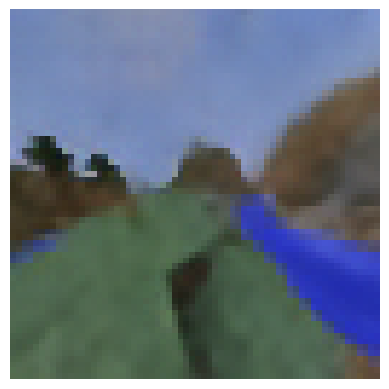

memory: deque([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=32)
persistent actions: ['forward']


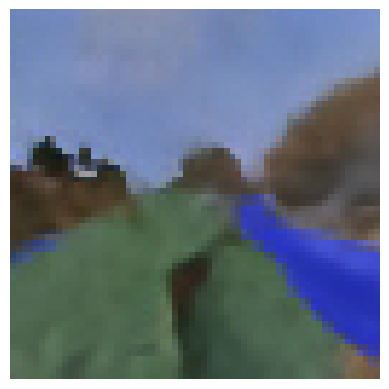

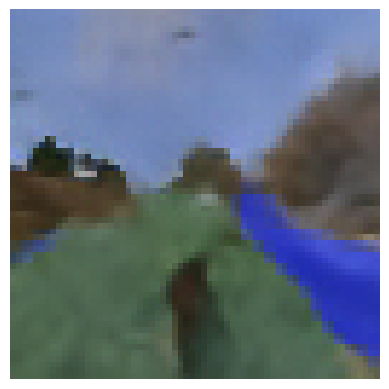

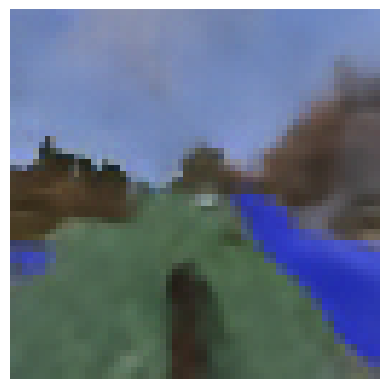

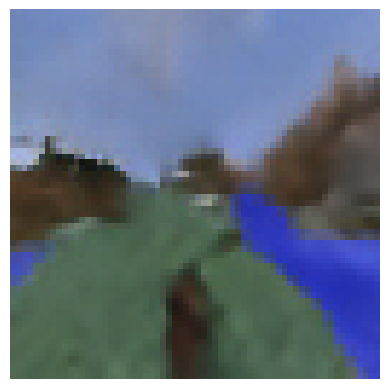

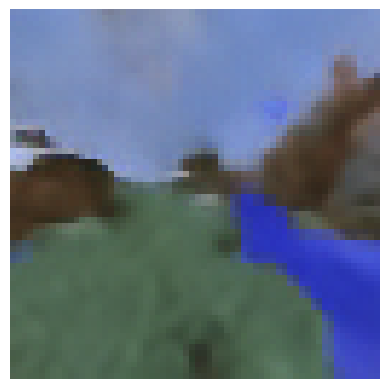

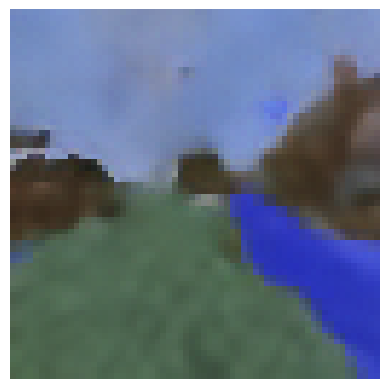

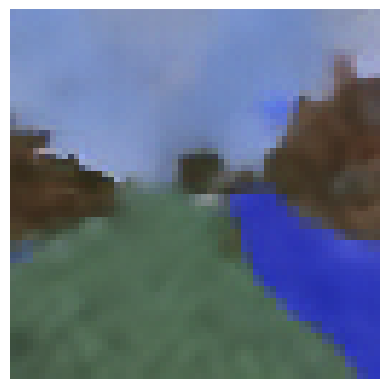

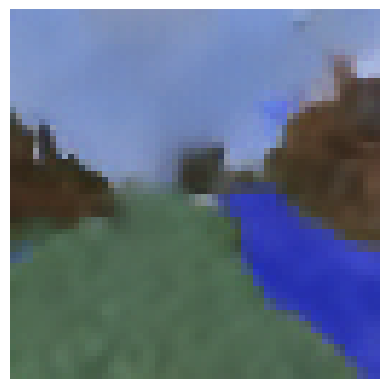

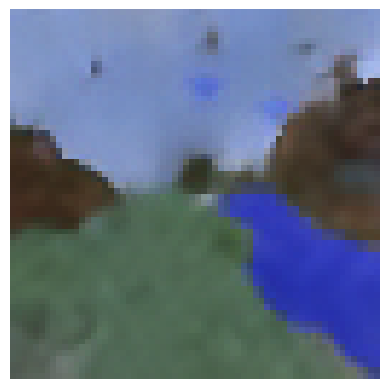

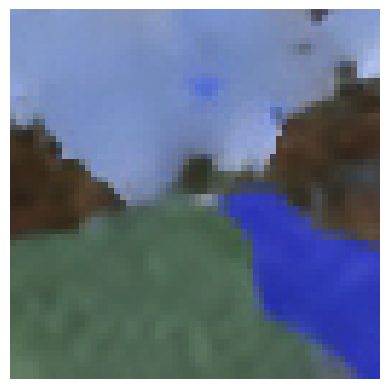

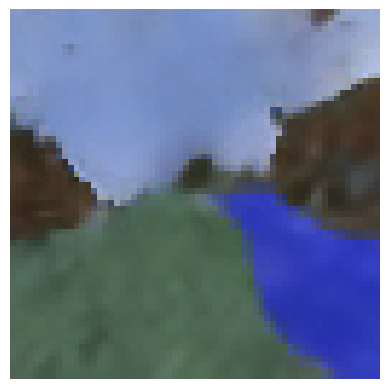

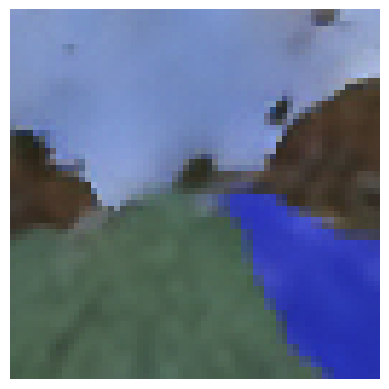

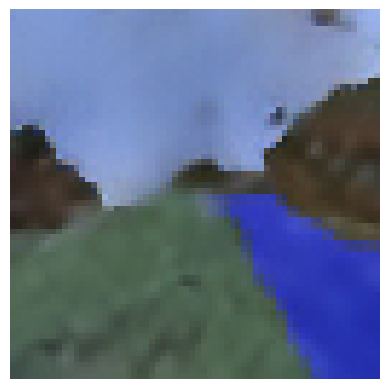

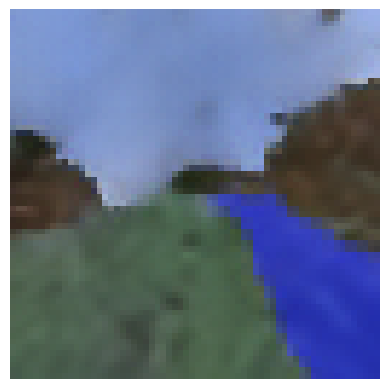

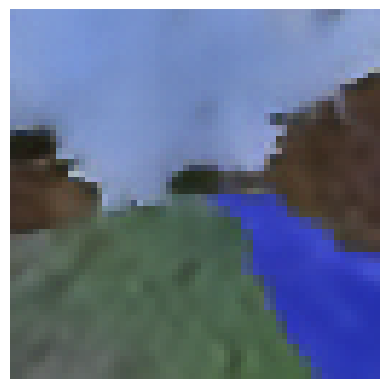

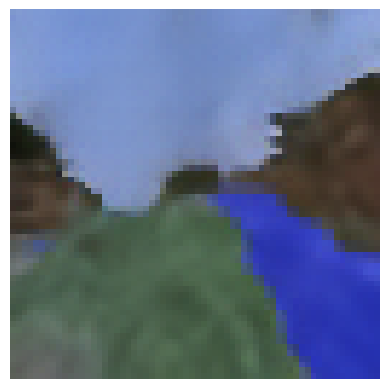

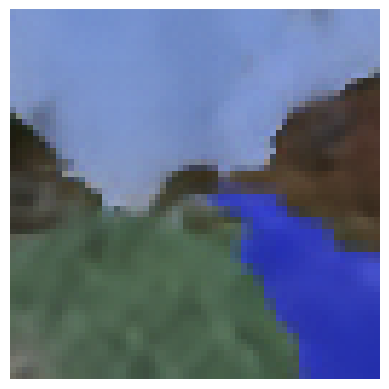

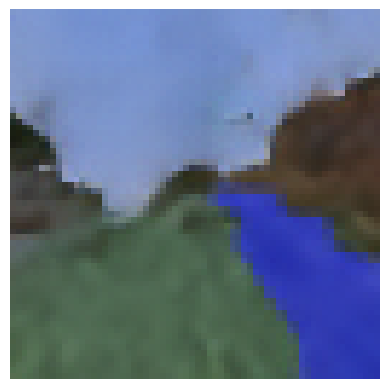

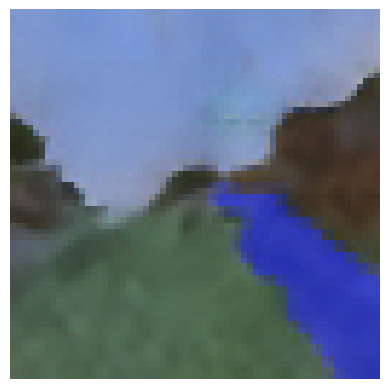

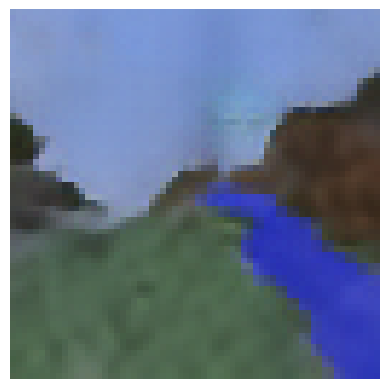

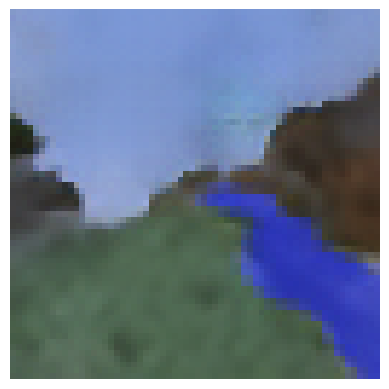

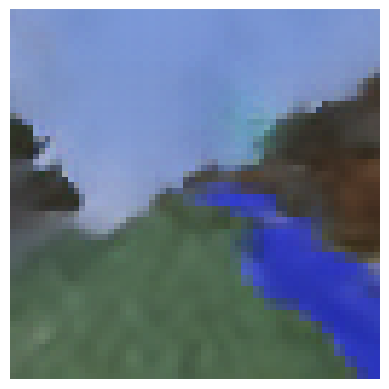

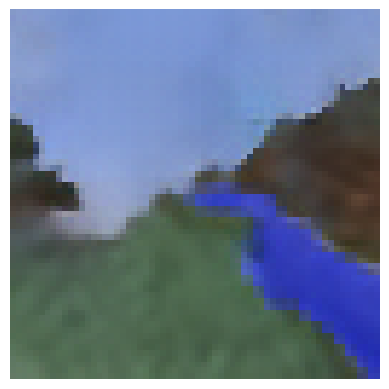

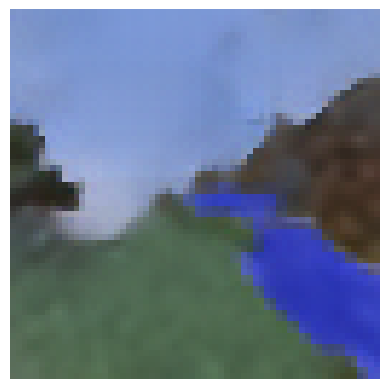

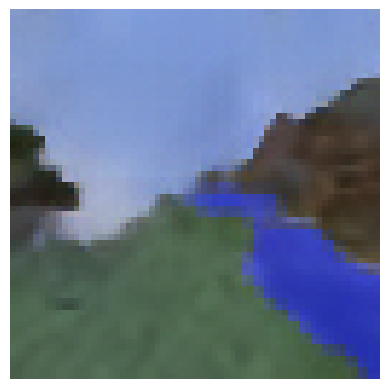

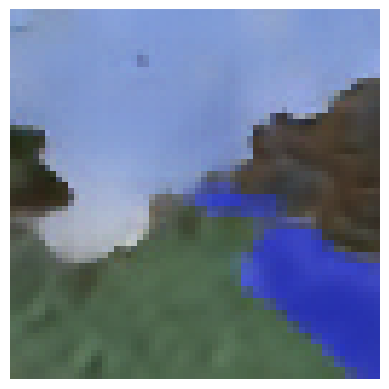

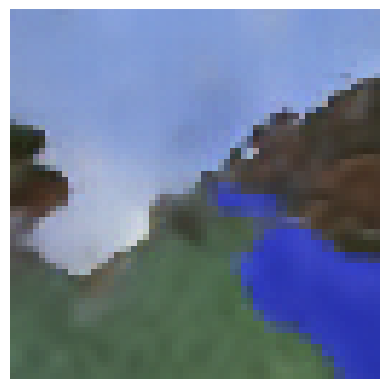

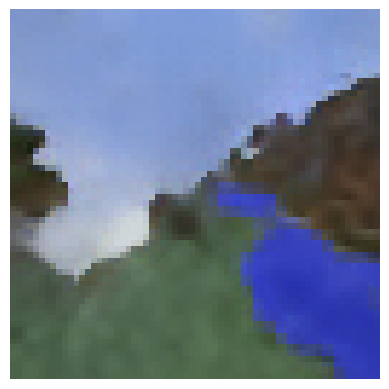

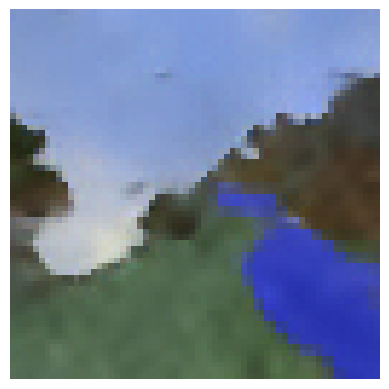

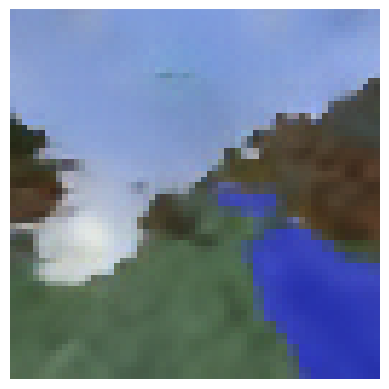

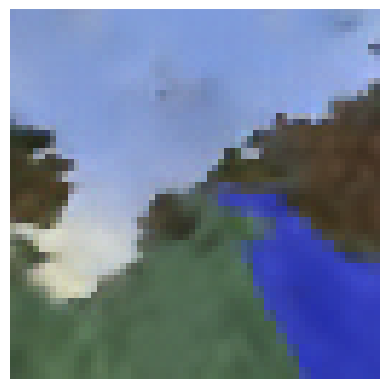

In [55]:
# generate imagined sequence
generated_frames = generate_sequence(model_name, dataset[start, CURRENT_POV_START:NEXT_POV_START], dataset[start, MEMORY_START:CURRENT_POV_START], 
                                     num_frames, actions=['forward'], erase_memory=False, temperature=1.00, user_action_input=False)

In [53]:
# save generated frames
save_frames_as_png(generated_frames) 

In [50]:
# check accuracy
check_accuracy(model_name, dataset[start:start+16], temperature=1.0)

accuracy: 0.3642578125
